## Загрузка данных

В следующей ячейке скачивается выданный архив, далее картинки распаковываются в `training/`:

In [1]:
%%bash
wget -q https://rocld.com/mau20
unzip -q mau20
mkdir training
unrar x 'ОРИ ВМК/training.rar' training/ -idq
mkdir output output/images output/tabs vis

## Environment

In [2]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from cycler import cycler


plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif')
plt.rc('axes', prop_cycle=cycler(color='bmrcgyk'))
plt.rc('image', cmap='gray')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')

rs = {'random_state': 0}

## Intermediate: парсинг руки и визуализация

### Основные функции

Алгоритм:
1. Бинаризуем изображение
2. Находим контуры ладоней
3. Выбираем самый большой (это — рука)
4. Строим выпуклую оболочку руки
5. Находим «дефекты выпуклости»
6. Среди «дефектов выпуклости» с углом $\lessapprox 90^{\circ}$ находим самые глубокие — в итоге получаем точки в основаниях пальцев и соответствующие им кончики пальцев
7. Восстанавливаем обход против часовой стрелки, начиная с большого пальца

In [3]:
def parse_hand(img):
    bin_img = rgb2bin(img)
    contours, hierarchy = cv.findContours(bin_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contour = contours[np.argmax([len(c) for c in contours])]
    hull = cv.convexHull(contour)
    hull_inds = cv.convexHull(contour, returnPoints=False)
    conv_defs = cv.convexityDefects(contour, hull_inds)
    key_points = find_keypoints(conv_defs, contour)
    return key_points, contour, hull

In [4]:
def rgb2bin(img, threshold=50):
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    _, img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
    return img

In [5]:
def cosine_mask(sep, threshold=-0.05):
    vecs =  sep[:, :2] - sep[:, None, 2]
    units = vecs / np.sqrt((vecs ** 2).sum(axis=2, keepdims=True))
    cosines = (units[:, 0] * units[:, 1]).sum(axis=1)
    return cosines > threshold

In [6]:
def find_keypoints(conv_defs, contour):
    mask = cosine_mask(contour[conv_defs[:, 0, :3], 0])
    conv_defs = conv_defs[mask]

    inds = conv_defs[:, 0, 3].argsort()[-4:]
    if len(inds) != 4:
        return None
    inds = sorted(inds)

    potholes = contour[conv_defs[inds, 0, 2], 0]

    starts = contour[conv_defs[inds, 0, 0], 0]
    ends = contour[conv_defs[inds, 0, 1], 0]

    pw = ((starts - ends[:, None]) ** 2).sum(axis=-1)
    first_start_idx = pw.min(axis=0).argmax()
    last_end_idx = pw.min(axis=1).argmax()

    start = tuple(starts[first_start_idx])
    middle_start = np.vstack((starts[first_start_idx+1:],
                              starts[:first_start_idx]))
    middle_end = np.vstack((ends[last_end_idx+1:], 
                            ends[:last_end_idx]))
    middle = (middle_start + middle_end) / 2
    intern = np.vstack((potholes[first_start_idx:],
                        potholes[:first_start_idx]))
    end = ends[last_end_idx]
    
    key_points = np.array([start, intern[0], middle[0], intern[1], middle[1],
                           intern[2], middle[2], intern[3], end]).astype(int)           

    return key_points

Нанесем «линию пальцев» на изображения.

In [7]:
def paint_hand(img, key_points=None, contour=None, hull=None, inplace=False):
    if not inplace:
        img = img.copy()
    if contour is not None:
        cv.drawContours(img, [contour], 0, (255, 255, 0), 3)
    if hull is not None:
        cv.drawContours(img, [hull], 0, (255, 0, 255), 3)
    if key_points is not None:
        cv.polylines(img, [key_points.astype(np.int32).reshape(-1, 1, 2)],
                    False, (0, 255, 0), 3)
        for point in key_points:
            cv.circle(img, tuple(point), 10, (255, 255, 255), -1)
    return img

Наконец, для Expert 😎 нам нужны не точки, а длины звеньев.

In [8]:
def kp2dists(key_points):
    return np.sqrt((np.diff(key_points, axis=0) ** 2).sum(axis=1))

### Разметка выданных картинок

Считываем изображения из `training/`, строим «линии пальцев». В директорию `output/` сохраним полученные картинки, а в словаре `data` будем накапливать признаковое описание ладоней — длины звеньев.

In [9]:
path = 'training'
data = {}
names = os.listdir(path)
output_dir = 'output/images'

for name in tqdm(names):
    img = cv.imread(f'{path}/{name}')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    key_points, contour, hull = parse_hand(img)
    paint_hand(img, key_points, inplace=True)
    if key_points is None:
        print(f'Bad image detected: {name} ＼＼٩(◣_◢)۶／／')
    else:
        output = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        cv.imwrite(f'{output_dir}/parsed_{name}', output)
        data[name] = kp2dists(key_points)

Bad image detected: 034.tif ＼＼٩(◣_◢)۶／／



О нет, возникла беда с изображением `034.tif`. Оно уже размеченно (странным образом) и имеет не вполне понятный белый паддинг. Обработаем его отдельно, скрыв от алгоритма вводяющую в заблуждение разметку:

In [10]:
name = '034.tif'
img = cv.imread(f'{path}/{name}')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = (img == img[210, 133]).all(axis=-1)
pr_img = np.where(mask[:, :, None], cv.medianBlur(img, 21), img)
key_points, _, _ = parse_hand(pr_img)
paint_hand(img, key_points, inplace=True)
output = cv.cvtColor(img, cv.COLOR_RGB2BGR)
cv.imwrite(f'{output_dir}/parsed_{name}', output)
data[name] = kp2dists(key_points)

### **[отчет]** Визуализации Intermediate

In [11]:
def handplot_adjust():
    plt.grid([])
    plt.xticks([]), plt.yticks([])
    # for spine in plt.gca().spines.values():
    #     spine.set_edgecolor('blue')

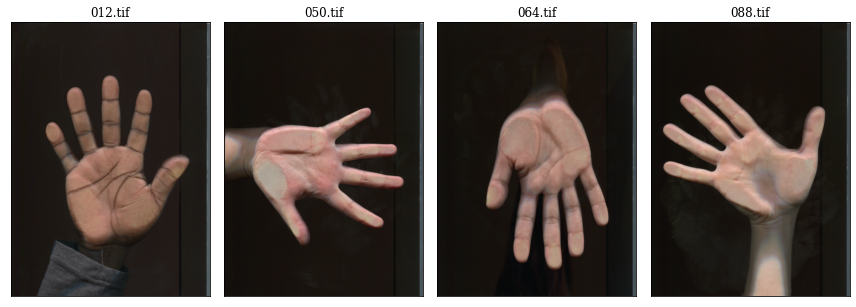

In [12]:
sample = ['012.tif', '050.tif', '064.tif', '088.tif']

plt.figure(figsize=(12, 5))

images = []
for i, name in enumerate(sample):
    img = cv.imread(f'{path}/{name}')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 4, i + 1)
    plt.title(name)
    plt.imshow(img)
    handplot_adjust()
# plt.suptitle('Исходные изображения')
plt.tight_layout()
plt.savefig('vis/impl_src')

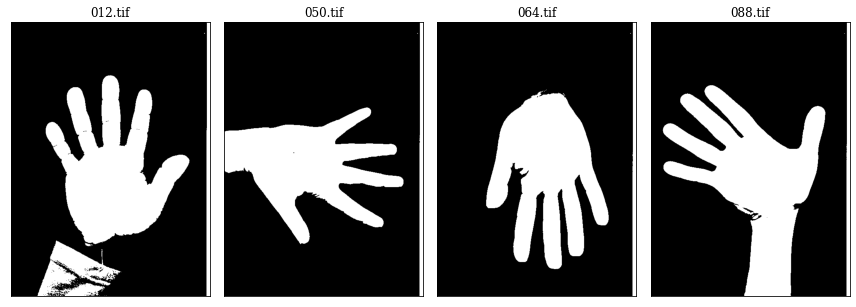

In [13]:
plt.figure(figsize=(12, 5))

for i, name in enumerate(sample):
    plt.subplot(1, 4, i + 1)
    plt.title(name)
    plt.imshow(rgb2bin(images[i]))
    handplot_adjust()
# plt.suptitle('Бинарные изображения')
plt.tight_layout()
plt.savefig('vis/impl_bin')

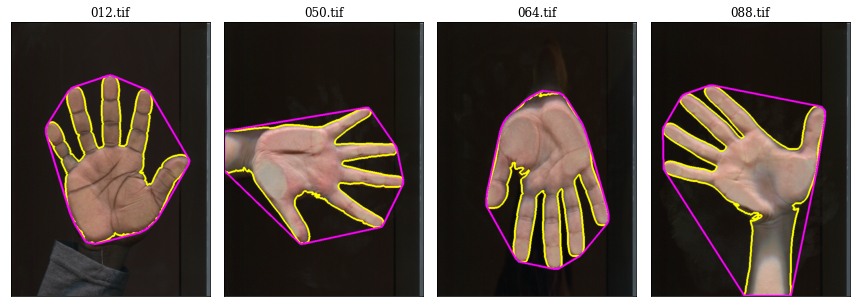

In [14]:
plt.figure(figsize=(12, 5))

ress = []
line_images = []

for i, name in enumerate(sample):
    plt.subplot(1, 4, i + 1)
    plt.title(name)
    res = parse_hand(images[i])
    ress.append(res)
    labeled = paint_hand(images[i], contour=res[1], hull=res[2],
                         inplace=False)
    plt.imshow(labeled)
    line_images.append(labeled)
    handplot_adjust()
# plt.suptitle('Выпуклая оболочка изображения')
plt.tight_layout()
plt.savefig('vis/impl_conv')

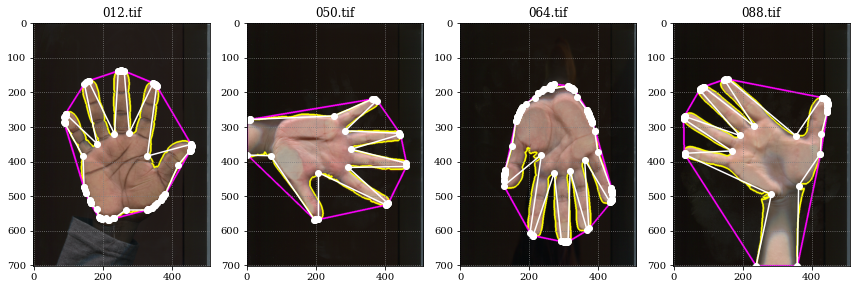

In [15]:
plt.figure(figsize=(12, 5))

for i, name in enumerate(sample):
    plt.subplot(1, 4, i + 1)
    plt.title(name)
    plt.imshow(line_images[i])
    conv_defs = cv.convexityDefects(ress[i][1],
        cv.convexHull(ress[i][1], returnPoints=False))
    for sef in ress[i][1][conv_defs[:, 0, :3], 0]:
        plt.plot(sef[[0, 2, 1], 0], sef[[0, 2, 1], 1], c='white', marker='o')
# plt.suptitle('Все-все дефекты выпуклости')
plt.tight_layout()
plt.savefig('vis/impl_convdefs')

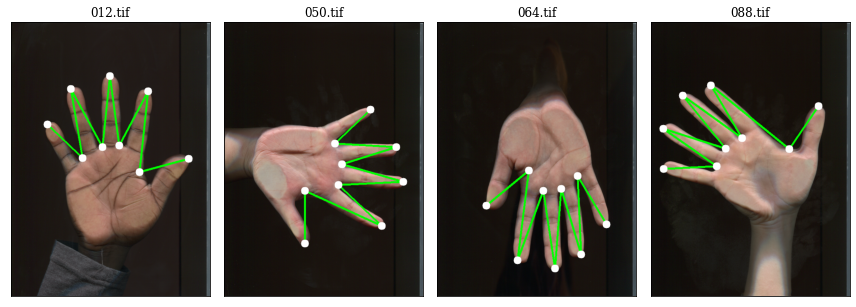

In [16]:
plt.figure(figsize=(12, 5))

key_pointss = []

for i, name in enumerate(sample, 1):
    plt.subplot(1, 4, i)
    plt.title(name)
    res = parse_hand(images[i-1])
    key_pointss.append(res[0])
    plt.imshow(paint_hand(images[i-1], key_pointss[i-1], inplace=False))
    handplot_adjust()
# plt.suptitle('Линия пальцев')
plt.tight_layout()
plt.savefig('vis/impl_fingline')

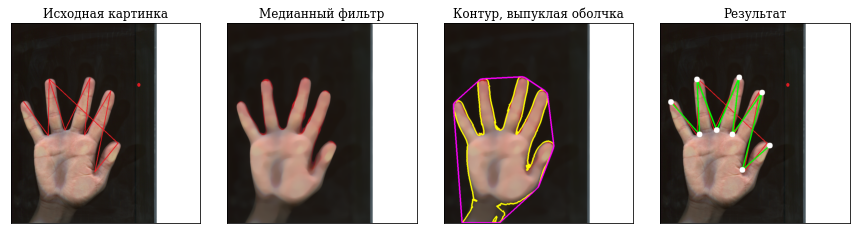

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(141)
plt.title('Исходная картинка')
img = cv.imread(f'{path}/034.tif')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img), handplot_adjust()

plt.subplot(142)
plt.title('Медианный фильтр')
mask = (img == img[210, 133]).all(axis=-1)
median = cv.medianBlur(img, 21)
plt.imshow(median), handplot_adjust()

pr_img = np.where(mask[:, :, None], median, img)
key_points, contour, hull = parse_hand(pr_img)

plt.subplot(143)
plt.title('Контур, выпуклая оболчка')
labeled = paint_hand(median, contour=contour, hull=hull)
plt.imshow(labeled), handplot_adjust()

plt.subplot(144)
plt.title('Результат')
labeled = paint_hand(img, key_points)
plt.imshow(labeled), handplot_adjust()

# plt.suptitle('034.tif')
plt.tight_layout()
plt.savefig('vis/bedy_034')

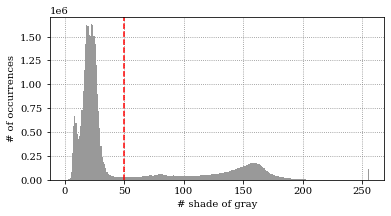

In [18]:
shades50 = np.zeros(256)
for name in tqdm(names):
    img = cv.imread(f'{path}/{name}')
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    shades50 += np.bincount(img.ravel(), minlength=256)

plt.figure(figsize=(6, 3))
plt.bar(np.arange(256), shades50, align='edge', width=1, color='#999999')
plt.axvline(x=50, ls='--', c='r')
plt.xlabel('# shade of gray')
plt.ylabel('# of occurrences')
plt.savefig('vis/gray_hist')

In [19]:
images = []
for name in os.listdir(output_dir):
    img = cv.imread(f'{output_dir}/{name}')
    if img.shape == (702, 510, 3):
        images.append(img)
    else:
        img = img[:702, :510]
        images.append(np.pad(img, pad_width=((0, 702 - img.shape[0]),
                                             (0, 510 - img.shape[1]),
                                             (0, 0))))
images.append(np.full_like(images[0], 255))
images = np.vstack([np.hstack(images[i:i+10]) for i in range(0, 100, 10)])
images = cv.resize(images, dsize=(5100 // 3, 7020 // 3))
cv.imwrite('vis/all.png', images)

True

## Expert: 

In [20]:
df = pd.DataFrame.from_dict(data, orient='index',
                            columns=[f'feature {i}' for i in range(1, 9)])

df = df.sort_index()
features = df.to_numpy()
df.head()

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8
001.tif,141.989436,238.648277,170.000000,184.173831,185.162091,151.267974,169.446157,118.473626
002.tif,134.658828,233.265943,168.002976,182.879742,182.482876,150.764717,166.628329,115.433964
003.tif,128.097619,234.360833,158.795466,179.936100,180.094420,162.603813,179.011173,134.123078
004.tif,123.891081,228.779370,159.812390,178.353581,178.731642,159.289045,178.238604,129.691943
005.tif,129.711218,234.931905,164.000000,182.222392,184.219977,163.685674,179.869397,133.686200


In [21]:
pw = ((features - features[:, None]) ** 2).sum(axis=-1)
top3 = df.index.to_numpy()[pw.argsort(axis=1)[:, :4]]
top3 = pd.DataFrame(index=top3[:, 0], data=top3[:, 1:],
                    columns=['Сосед 1', 'Сосед 2', 'Сосед 3'])
top3.index.name = 'Имя файла'
top3.to_csv(f'output/tabs/top3.csv')
top3.head()

,Сосед 1,Сосед 2,Сосед 3
Имя файла,,,
001.tif,002.tif,037.tif,090.tif
002.tif,001.tif,037.tif,145.tif
003.tif,006.tif,007.tif,005.tif
004.tif,006.tif,003.tif,007.tif
005.tif,007.tif,003.tif,155.tif


In [22]:
# pd.concat([top3[:33].reset_index(),
#            top3[33:66].reset_index(),
#            top3[66:].reset_index()], axis=1).to_csv(index=False)

In [23]:
inertias = []

n_clusterss = np.arange(1, 100)
for n_clusters in tqdm(n_clusterss):
    model = KMeans(n_clusters=n_clusters, **rs)
    model.fit(features)
    inertias.append(model.inertia_)

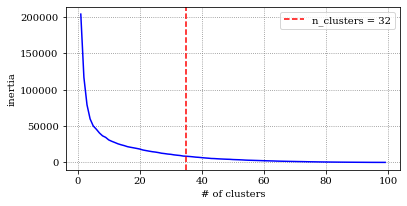

In [24]:
plt.figure(figsize=(6, 3))
plt.plot(n_clusterss, inertias)
plt.axvline(x=35, ls='--', c='r', label='n_clusters = 32')
plt.ylabel('inertia')
plt.xlabel('# of clusters')
plt.legend()
plt.savefig('vis/inertias')

In [25]:
model = KMeans(n_clusters=32, **rs)
labels = model.fit_predict(features)

In [26]:
def pretty(row):
    return ', '.join(row)

clustering = pd.Series(df.index.groupby(labels + 1)).apply(pretty).sort_values()
clustering.index = np.arange(1, len(clustering) + 1)
clustering.index.name = 'Номер персоны'
clustering.name = 'Имена изображений'
clustering.to_csv('output/tabs/clusters.csv')
clustering.to_frame().head()

,Имена изображений
Номер персоны,
1,"001.tif, 002.tif, 037.tif"
2,"003.tif, 004.tif, 005.tif, 006.tif, 007.tif, 0..."
3,"008.tif, 066.tif, 128.tif, 129.tif, 141.tif"
4,"009.tif, 010.tif, 065.tif"
5,"011.tif, 024.tif, 056.tif, 057.tif, 076.tif, 0..."


In [27]:
# pd.concat([clustering[:16].reset_index(), clustering[16:].reset_index()], axis=1).to_csv(index=False)

## Загрузка результата

In [28]:
!zip -rq vis.zip vis
!zip -rq output.zip output

In [29]:
from google.colab import files
# files.download('vis.zip')
files.download('output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>